In [85]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
rng = np.random.default_rng()

In [86]:
def ordered_state(width):
    return np.exp(2j * np.pi * np.zeros((width,width,width,width,4)))

def disordered_state(width):
    return np.exp(2j * np.pi * np.random.rand(width,width,width,width,4))

In [87]:
def run_lattice_heatbath(U_state,beta,n):
    """Perform n heatbath updates on the lattice state U_state."""
    for _ in range(n):
        lattice_heatbath_update(U_state,beta)

def lattice_heatbath_update(U_state,beta):
    """Perform a random heatbath update on the lattice state U_state."""
    width = len(U_state)
    link_index = random_link_index(width)
    U_state[link_index] = sample_link_variable(U_state,beta,link_index)

def random_link_index(width):
    """Return a random link index (n_x,n_y,n_z,kappa)"""
    return tuple(rng.integers(0,[width,width,width,width,4]))

def sample_link_variable(state,beta,link_index):
    """Sample link variable U = exp(i*theta)."""
    link_variable_sum = relevant_link_variable_sum(state,link_index)
    alpha = beta*np.real(link_variable_sum)
    phi = np.angle(link_variable_sum)
    while True:
        Z = rng.uniform(0,1)
        x = -1 + np.log(1 + (np.exp(2*alpha) - 1)*Z)/alpha

        Q = np.exp(alpha*(np.cos(np.pi/2*(1-x))-x))
        Q_max = np.exp(0.2105137*alpha)

        Z_prime = rng.uniform(0,1)
        if Q/Q_max > Z_prime:
            theta = np.pi*(1-x)/2 - phi
            return np.exp(1j*theta)

def relevant_link_variable_sum(state,link_index):
    """Return the sum of the link variables present in the plaquettes containing the relevant link,
    without the contribution of the link itself."""
    width = len(state)
    base = np.array(link_index[:4])
    kappa = link_index[-1]
    kappa_hat = get_unit_vector(kappa)

    result = 0
    for nu in range(4):
        if nu != kappa:
            nu_hat = get_unit_vector(nu)
            contribution = state[get_lattice_vector(base+kappa_hat,width)][nu]
            contribution *= state[get_lattice_vector(base+nu_hat,width)][kappa]
            contribution *= state[get_lattice_vector(base,width)][nu]
            result += contribution

    return result

def get_unit_vector(index):
    """Return the unit vector from the dimension index."""
    vector = np.zeros(4).astype(int)
    vector[index] = 1
    return vector

def get_plaquette_values(state,vertex,mu_vector,nu_vector):
    """Return the plaquette link variable values from the plaquette vertex and two plane vectors."""
    width = len(state)

    vertex = np.array(vertex)
    mu_vector, nu_vector = np.array(mu_vector), np.array(nu_vector)
    mu_index, nu_index = get_unit_vector_index(mu_vector), get_unit_vector_index(nu_vector)

    return [
        state[get_lattice_vector(vertex,width)][mu_index],
        state[get_lattice_vector(vertex + mu_vector,width)][nu_index],
        np.conj(state[get_lattice_vector(vertex + mu_vector + nu_vector,width)][nu_index]),
        np.conj(state[get_lattice_vector(vertex,width)][nu_index])
    ]

def get_unit_vector_index(vector):
    """Return the index of the unit vector."""
    return np.flatnonzero(vector)[0].astype(int)

def get_lattice_vector(vector,width):
    """Get the lattice vector periodic with the lattice width."""
    return tuple(map(lambda i: i % width, vector))

In [88]:
def lattice_action(state):
    """Compute action of the lattice state."""
    action = 0
    plaquette_corners = get_unique_unoriented_plaquette_corners(len(state))
    for corners in plaquette_corners:
        if len(get_plane_vectors_from_corners(corners)) == 2:
            values = get_plaquette_values_from_corners(state,corners)
            action += 1 - np.real(np.prod(values))
    return action

def get_unique_unoriented_plaquette_corners(width):
    """Return pairs of vertices forming the corners of only unique and unoriented lattice plaquettes."""
    unique_unoriented_corners = []
    for corners in get_plaquettes_corners(width):
        sorted_corners = tuple(sorted(corners))
        if sorted_corners not in unique_unoriented_corners:
            unique_unoriented_corners.append(sorted_corners)
    return unique_unoriented_corners

def get_plaquettes_corners(width):
    """Return pairs of vertices forming the corners of lattice plaquettes."""
    plaquette_corners = []
    for vertex in lattice_vertices(width):
        for mu_vector,nu_vector in get_plane_vectors():
            plaquette_corners.append([
                get_lattice_vector(vertex,width),
                get_lattice_vector(vertex + mu_vector,width),
                get_lattice_vector(vertex + nu_vector,width),
                get_lattice_vector(vertex + mu_vector + nu_vector,width)
            ])
    return plaquette_corners

def lattice_vertices(width):
    """Compute the vertices of the lattice with given width."""
    vertices = []
    for n_x in range(width):
        for n_y in range(width):
            for n_z in range(width):
                for n_t in range(width):
                    vertex = (n_x,n_y,n_z,n_t)
                    vertices.append(vertex)
    return vertices

def get_plane_vectors():
    """Return pairs of vectors (mu_vector,nu_vector) forming unique planes on the lattice."""
    plane_vectors = []
    for mu in range(4):
        for nu in range(4):
            if mu < nu:
                plane_vectors.append((get_unit_vector(mu),get_unit_vector(nu)))
    return plane_vectors

def get_plaquette_values_from_corners(state,corners):
    """Return the plaquette link variable values from the four corners of the plaquette."""
    corners = tuple(sorted(corners))

    vertex = np.array(corners[0])
    plane_vectors = get_plane_vectors_from_corners(corners)
    mu_vector, nu_vector = np.array(plane_vectors[0]), np.array(plane_vectors[1])

    if get_unit_vector_index(mu_vector) > get_unit_vector_index(nu_vector):
        mu_vector, nu_vector = nu_vector, mu_vector

    return get_plaquette_values(state,vertex,mu_vector,nu_vector)

def get_plane_vectors_from_corners(corners):
    plane_vectors = []
    for i in range(4):
        for j in range(4):
            difference_vector = tuple(np.abs(np.array(corners[i]) - np.array(corners[j])))
            is_unit_vector = np.linalg.norm(difference_vector) == 1.0
            if is_unit_vector and difference_vector not in plane_vectors:
                plane_vectors.append(difference_vector)
    return plane_vectors

In [89]:
def run_simulation(state,beta,k,n,measurements):
    """Run the simulation with k equilibration sweeps and n measurement sweeps.
    Returns the action measurement results."""
    num_links = 4*len(state)**4

    # equilibrate
    run_lattice_heatbath(state,beta,k*num_links)

    # measure
    results = np.empty(measurements)
    for i in range(measurements):
        run_lattice_heatbath(state,beta,n*num_links)
        results[i] = lattice_action(state)
        print(i)

    return results

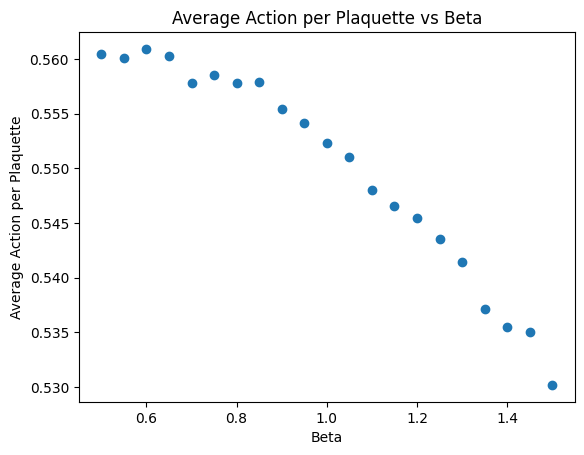

In [133]:
width = 4
equil_sweeps = 1
measure_sweeps = 1

beta_values_range1 = np.arange(0.5, 0.85, 0.05)
beta_values_range2 = np.arange(0.85, 1.15, 0.05)
beta_values_range3= np.arange(1.15, 1.5, 0.05)
beta_values = np.concatenate((beta_values_range1,beta_values_range2,beta_values_range3))

measurements1 = np.full_like(beta_values_range1, 400, dtype=int)
measurements2 = np.full_like(beta_values_range2, 7500, dtype=int)
measurements3 = np.full_like(beta_values_range3, 400, dtype=int)
measurements_per_beta = np.concatenate((measurements1,measurements2,measurements3))

average_actions = []

for beta, measurements in zip(beta_values, measurements_per_beta):
    with h5py.File('lattice.hdf5', 'a') as f:
        dataset_name = f"beta{beta}-average-action-per-iterations"
        if dataset_name not in f:
            U_state = ordered_state(width)
            action_measurements = run_simulation(U_state, beta, equil_sweeps, measure_sweeps, measurements)
            f.create_dataset(dataset_name, data=action_measurements)

    with h5py.File('lattice.hdf5', 'r') as f:
        action_measurements = f[dataset_name][()]

        num_plaquettes = len(get_unique_unoriented_plaquette_corners(width))
        actions = [action / num_plaquettes for action in action_measurements]

        average_actions.append(np.mean(actions))

# Plot the average action per plaquette vs. beta
plt.scatter(beta_values, average_actions)
plt.xlabel('Beta')
plt.ylabel('Average Action per Plaquette')
plt.title('Average Action per Plaquette vs Beta')
plt.show()